In [1]:
import json
import os

import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import s3fs
import xarray as xr
from dask.distributed import Client as DaskClient
from dotenv import load_dotenv
from odc.stac import load
from planetary_computer import sign_url
from shapely.geometry import shape

In [2]:
load_dotenv()

True

In [3]:
dask_client = DaskClient()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44651/status,
Dashboard: http://127.0.0.1:44651/status,Workers: 4
Total threads: 8,Total memory: 9.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34447,Workers: 0
Dashboard: http://127.0.0.1:44651/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35729,Total threads: 2
Dashboard: http://127.0.0.1:46151/status,Memory: 2.40 GiB
Nanny: tcp://127.0.0.1:45055,


In [4]:
m = leafmap.Map(draw_export=True)
m.add_basemap("ESA WorldCover 2021")
m.add_legend(builtin_legend="ESA_WorldCover")
m.add_vector("aoi.geojson")
m

In [5]:
with open("aoi.geojson") as file:
    area_of_interest = json.load(file)
    area_of_interest = area_of_interest["features"][0]["geometry"]
    geom = shape(area_of_interest)
    bbox = list(geom.bounds)

In [43]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
collection = "landsat-c2-l2"
bbox = bbox
start_date = "2023-08"
end_date = "2025-07"

In [44]:
search = catalog.search(
    collections=[collection],
    bbox=bbox,
    datetime=f"{start_date}/{end_date}",
)
items = search.item_collection()

In [45]:
len(items)

406

In [46]:
data = load(
    items,
    bands=["red", "nir08", "qa_pixel"],
    bbox=bbox,
    chunks={"x": 2048, "y": 2048},
    resolution=300,
    groupby="solar_day",
    patch_url=sign_url,
)

In [47]:
data

<xarray.Dataset> Size: 368MB
Dimensions:      (y: 452, x: 692, time: 196)
Coordinates:
  * y            (y) float64 4kB 1.57e+06 1.57e+06 ... 1.436e+06 1.435e+06
  * x            (x) float64 6kB 4.512e+05 4.515e+05 ... 6.582e+05 6.585e+05
    spatial_ref  int32 4B 32630
  * time         (time) datetime64[ns] 2kB 2023-08-02T08:17:21.158840 ... 202...
Data variables:
    red          (time, y, x) uint16 123MB dask.array<chunksize=(1, 452, 692), meta=np.ndarray>
    nir08        (time, y, x) uint16 123MB dask.array<chunksize=(1, 452, 692), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 123MB dask.array<chunksize=(1, 452, 692), meta=np.ndarray>

In [48]:
# Mask out nodata and cloud pixels
# Bit 3 is cloud shadow, bit 4 is cloud, and bit 0 is nodata
mask_bits = 0b00011001

mask = (data.qa_pixel & mask_bits) != 0

data = data.where(~mask, other=np.nan).drop_vars("qa_pixel")

In [49]:
ndvi = (data.nir08 - data.red) / (data.nir08 + data.red)
data["ndvi"] = ndvi.clip(-1, 1)
data = data.drop_vars(["red", "nir08"])

In [51]:
data = data.compute()

In [52]:
data.to_zarr("data/ndvi.zarr", mode="w", consolidated=True)

In [53]:
# Start here if data is already downloaded
data = xr.open_zarr("data/ndvi.zarr", chunks={"time": -1, "x": 2048, "y": 2048})
ndvi = data.ndvi

In [54]:
ndvi

<xarray.DataArray 'ndvi' (time: 196, y: 452, x: 692)> Size: 490MB
dask.array<open_dataset-ndvi, shape=(196, 452, 692), dtype=float64, chunksize=(196, 452, 692), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6kB 4.512e+05 4.515e+05 ... 6.582e+05 6.585e+05
    spatial_ref  int32 4B ...
  * y            (y) float64 4kB 1.57e+06 1.57e+06 ... 1.436e+06 1.435e+06
  * time         (time) datetime64[ns] 2kB 2023-08-02T08:17:21.158840 ... 202...

In [55]:
ndvi_time_series = ndvi.mean(dim=["x", "y"])

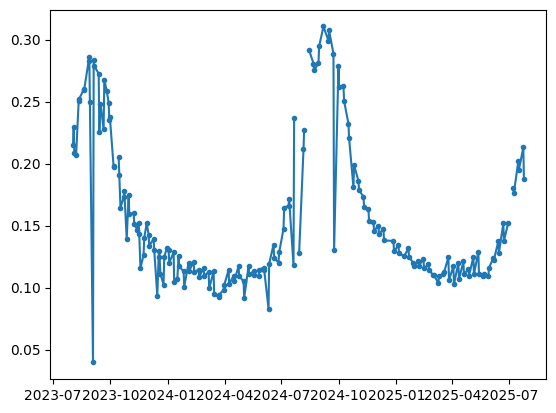

In [56]:
plt.plot(
    ndvi_time_series["time"].values,
    ndvi_time_series.values,
    marker=".",
)

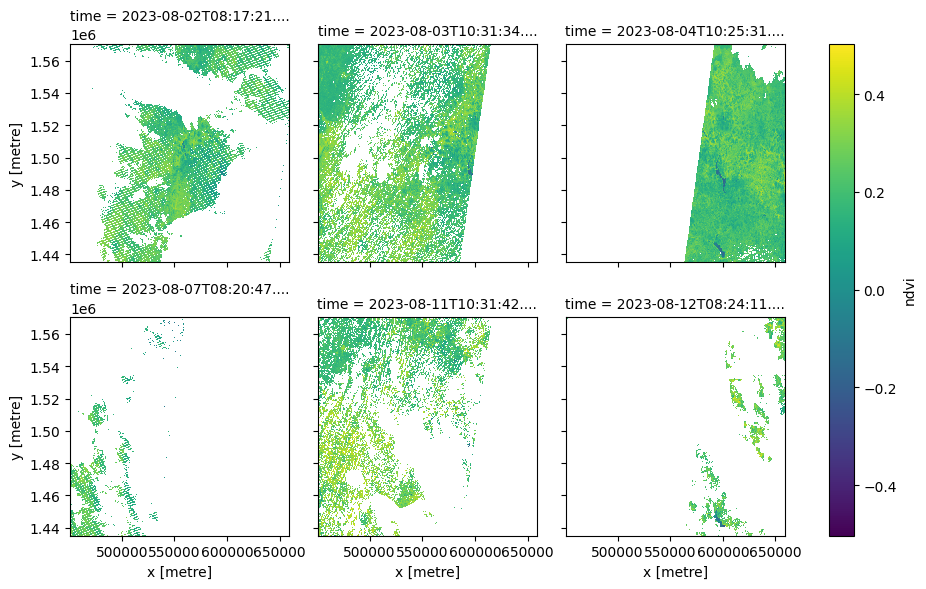

In [57]:
ndvi.isel(time=slice(0, 6)).plot(col="time", col_wrap=3, cmap="viridis")

In [58]:
eight_day = data.ndvi.resample(time="8D").max()
eight_day = eight_day.chunk({"time": -1})

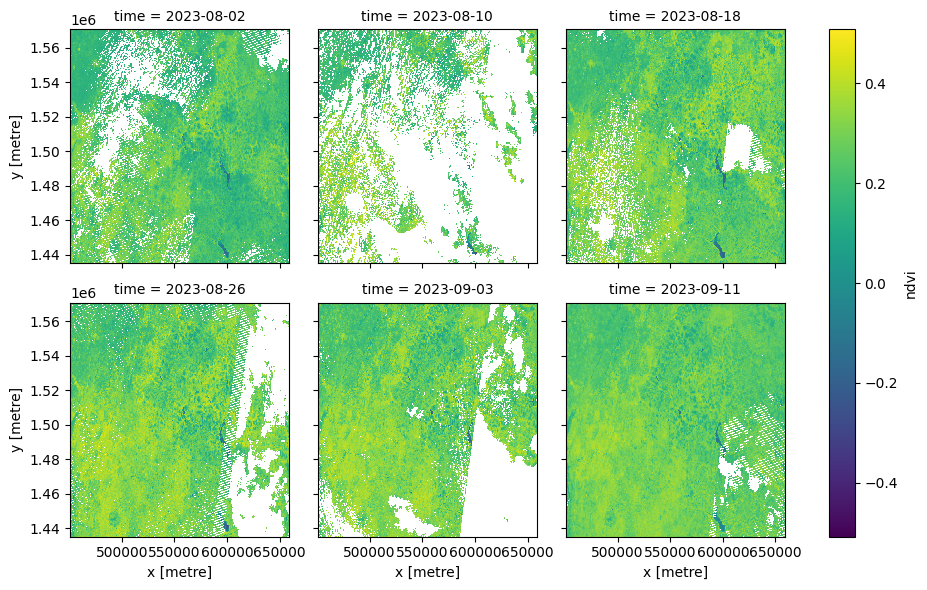

In [59]:
eight_day.isel(time=slice(0, 6)).plot(col="time", col_wrap=3, cmap="viridis")

In [60]:
filled = eight_day.interpolate_na("time", method="linear").bfill("time").ffill("time")

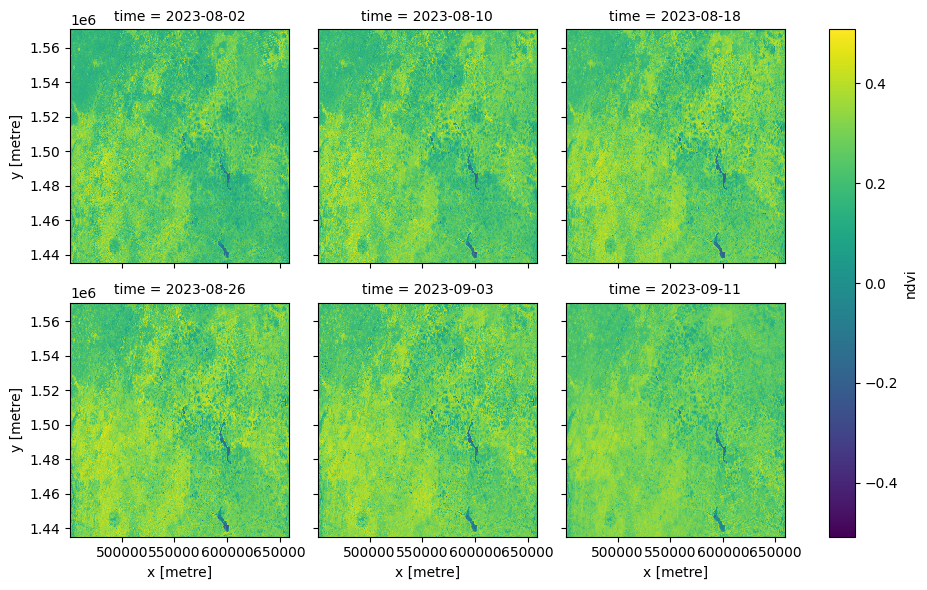

In [61]:
filled.isel(time=slice(0, 6)).plot(col="time", col_wrap=3, cmap="viridis")

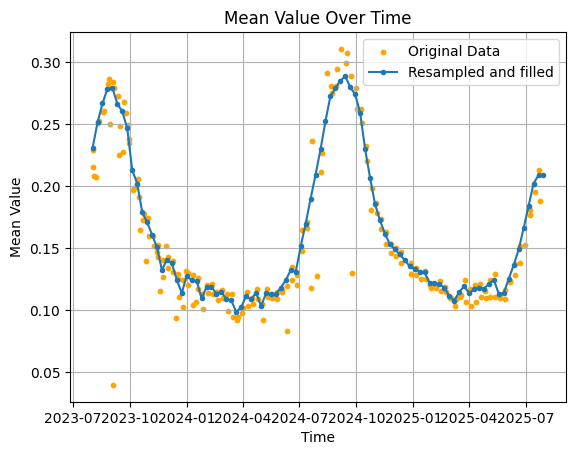

In [63]:
mean = ndvi.mean(dim=["x", "y"])
filled_mean = filled.mean(dim=["x", "y"])

plt.scatter(
    mean["time"].values,
    mean.values,
    s=10,
    color="orange",
    label="Original Data",
)
plt.plot(
    filled_mean["time"].values,
    filled_mean.values,
    marker=".",
    label="Resampled and filled",
)
plt.title("Mean Value Over Time")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()

In [64]:
filled.to_zarr("data/ndvi_processed.zarr", mode="w", consolidated=True)

In [65]:
bucket_name = os.environ["S3_BUCKET"]
s3_path = f"{bucket_name}/ndvi_processed.zarr"
fs = s3fs.S3FileSystem()
fs.put("./data/ndvi_processed.zarr/", s3_path, recursive=True)

[None, None, None, None, None, None, None, None, None, None, None]

In [67]:
fs.put("last_end_date.txt", bucket_name)
fs.put("aoi.geojson", bucket_name)

[None]